Projet IA - Algorithmique

Prédiction du risque de crise d'asthme en fonction de la météo et des symptômes du patient

François DESLANDES, Agathe LESCHIERA, Solène VON MULLEM


In [30]:
# Importation des bibliothèques nécessaires
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier

## 📥 Chargement des données téléchargées

### Instructions pour télécharger les données :

**Airparif :**

1. Aller sur https://data.airparif.asso.fr/
2. Télécharger les données historiques (format CSV ou Excel)
3. Sauvegarder dans le dossier du projet

**Santé Publique France :**

1. Aller sur https://www.data.gouv.fr/fr/organizations/sante-publique-france/
2. Chercher "urgences respiratoires" ou "SOS Médecins"
3. Télécharger les CSV

**Données Climatologiques Datagouv :**

- Télécharger depuis https://www.data.gouv.fr/datasets/donnees-climatologiques-de-base-quotidiennes/


In [31]:
# Chargement des données Airparif (2018-2025)
import glob
from pathlib import Path


def load_airparif_data():
    """
    Charge toutes les données Airparif de 2018 à 2025
    Format: première colonne = datetime, colonnes 2-4 = NO2, NO, NOX
    """
    airparif_path = "data/airparif"
    files = glob.glob(f"{airparif_path}/AP_*")

    all_data = []

    for file in sorted(files):
        year = Path(file).name.split("_")[1]
        print(f"Chargement {year}...", end=" ")

        # Lire le CSV en sautant les 6 premières lignes (headers)
        # Garder seulement les 4 premières colonnes : datetime, NO2, NO, NOX
        df = pd.read_csv(
            file,
            skiprows=6,
            usecols=[0, 1, 2, 3],  # Colonnes datetime, NO2, NO, NOX
            names=["datetime", "NO2", "NO", "NOX"],
            parse_dates=["datetime"],
        )

        # Nettoyer les données
        df = df.dropna(subset=["datetime"])  # Supprimer lignes sans date

        # Convertir les polluants en numérique
        for col in ["NO2", "NO", "NOX"]:
            df[col] = pd.to_numeric(df[col], errors="coerce")

        # Ajouter l'année
        df["year"] = year

        all_data.append(df)
        print(f"✓ ({len(df)} lignes)")

    # Concaténer toutes les années
    df_airparif_full = pd.concat(all_data, ignore_index=True)

    print(f"\n✅ Données Airparif chargées : {df_airparif_full.shape}")
    print(
        f"Période : {df_airparif_full['datetime'].min()} → {df_airparif_full['datetime'].max()}"
    )
    print("\nStatistiques NO2 (µg/m³) :")
    print(df_airparif_full["NO2"].describe())

    return df_airparif_full


df_airparif = load_airparif_data()
df_airparif.head()

Chargement 2018... ✓ (8760 lignes)
Chargement 2019... ✓ (8760 lignes)
Chargement 2020... ✓ (8784 lignes)
Chargement 2021... ✓ (8760 lignes)
Chargement 2022... ✓ (8760 lignes)
Chargement 2023... ✓ (8760 lignes)
Chargement 2024... ✓ (8784 lignes)
Chargement 2025... ✓ (8328 lignes)

✅ Données Airparif chargées : (69696, 5)
Période : 2018-01-01 01:00:00+00:00 → 2025-12-14 00:00:00+00:00

Statistiques NO2 (µg/m³) :
count    65781.000000
mean        24.955630
std         17.066025
min          0.000000
25%         12.500000
50%         19.900000
75%         32.800000
max        163.900000
Name: NO2, dtype: float64


,datetime,NO2,NO,NOX,year
0,2018-01-01 01:00:00+00:00,5.0,0.0,5.7,2018
1,2018-01-01 02:00:00+00:00,5.0,0.0,5.7,2018
2,2018-01-01 03:00:00+00:00,6.0,0.0,5.7,2018
3,2018-01-01 04:00:00+00:00,7.0,0.0,7.2,2018
4,2018-01-01 05:00:00+00:00,8.0,0.0,9.6,2018


In [32]:
# Chargement des données d'hospitalisation - Île-de-France uniquement
df_hospitalisations = pd.read_csv(
    "data/hostpitalisations/asthme-passages-aux-urgences-et-actes-sos-medecins-region.csv",
    parse_dates=["1er jour de la semaine"],
)

print("✅ Données d'hospitalisations chargées")
print(f"Shape totale: {df_hospitalisations.shape}")

# Filtrer uniquement l'Île-de-France
df_hospitalisations_idf = df_hospitalisations[
    df_hospitalisations["Région"] == "Île-de-France"
].copy()

# Filtrer "Tous âges" pour avoir une vue globale
# df_hospitalisations_idf = df_hospitalisations_idf[df_hospitalisations_idf["Classe d'âge"] == 'Tous âges']

print(f"\n🎯 Données Île-de-France (Tous âges) : {df_hospitalisations_idf.shape}")
print(
    f"Période : {df_hospitalisations_idf['1er jour de la semaine'].min()} → {df_hospitalisations_idf['1er jour de la semaine'].max()}"
)
print("\nAperçu :")
df_hospitalisations_idf

✅ Données d'hospitalisations chargées
Shape totale: (22320, 8)

🎯 Données Île-de-France (Tous âges) : (1240, 8)
Période : 2019-12-30 00:00:00 → 2025-12-01 00:00:00

Aperçu :


,1er jour de la semaine,Semaine,Région Code,Région,Classe d'âge,Taux de passages aux urgences pour asthme,Taux d'hospitalisations après passages aux urgences pour asthme,Taux d'actes médicaux SOS médecins pour asthme
413,2019-12-30,2020-S01,11,Île-de-France,15-64 ans,807.391377,1411.657559,1034.820305
414,2020-01-06,2020-S02,11,Île-de-France,00-14 ans,2784.846942,6946.826758,1213.798978
415,2020-01-06,2020-S02,11,Île-de-France,65 ans ou plus,484.496124,420.521447,1446.051168
416,2020-01-13,2020-S03,11,Île-de-France,65 ans ou plus,533.594686,310.296192,1274.312542
417,2020-01-13,2020-S03,11,Île-de-France,Tous âges,1449.758081,1974.753156,1252.463602
...,...,...,...,...,...,...,...,...
21729,2025-10-27,2025-S44,11,Île-de-France,15-64 ans,704.381997,811.581487,1755.435867
21730,2025-10-27,2025-S44,11,Île-de-France,65 ans ou plus,348.010289,400.421496,2072.538860
21731,2025-11-17,2025-S47,11,Île-de-France,00-14 ans,7222.195038,18494.271686,3329.864724
21732,2025-11-24,2025-S48,11,Île-de-France,00-14 ans,6676.665758,17110.874200,3772.563177


In [33]:
# Chargement des données météo (CSV)
# Source : Météo France - Station d'Aubervilliers (Seine-Saint-Denis)
# Période : 2020-2025 (pour correspondre aux données d'hospitalisation)

# Charger les données 1950-2023
df_meteo_previous = pd.read_csv(
    "data/meteo/Q_93_previous-1950-2023_RR-T-Vent.csv", sep=";", low_memory=False
)

# Charger les données 2024-2025
df_meteo_latest = pd.read_csv(
    "data/meteo/Q_93_latest-2024-2025_RR-T-Vent.csv", sep=";", low_memory=False
)

# Combiner les deux dataframes
df_meteo = pd.concat([df_meteo_previous, df_meteo_latest], ignore_index=True)

print("✅ Données météo chargées avec succès")
print(f"Shape totale: {df_meteo.shape}")
print(
    f"\nStation météo : {df_meteo['NOM_USUEL'].iloc[0] if 'NOM_USUEL' in df_meteo.columns else 'N/A'}"
)

# Conversion de la date AAAAMMJJ en datetime
if "AAAAMMJJ" in df_meteo.columns:
    df_meteo["date"] = pd.to_datetime(
        df_meteo["AAAAMMJJ"], format="%Y%m%d", errors="coerce"
    )
    df_meteo = df_meteo.dropna(subset=["date"])  # Supprimer les dates invalides

    # 🎯 Filtrer uniquement à partir de 2020 (pour correspondre aux hospitalisations)
    df_meteo = df_meteo[df_meteo["date"] >= "2020-01-01"].copy()

    print(
        f"Période (après filtre ≥ 2021) : {df_meteo['date'].min().date()} → {df_meteo['date'].max().date()}"
    )
    print(f"Nombre de jours : {len(df_meteo)}")

# Colonnes principales d'intérêt
colonnes_importantes = {
    "RR": "Précipitations (mm)",
    "TN": "Température minimale (°C)",
    "TX": "Température maximale (°C)",
    "TM": "Température moyenne (°C)",
    "FFM": "Vent moyen (m/s)",
    "FXY": "Vent max (m/s)",
}

colonnes_presentes = [
    col for col in colonnes_importantes.keys() if col in df_meteo.columns
]
print(f"\n📊 Colonnes météo disponibles : {', '.join(colonnes_presentes)}")

# Convertir en numérique et nettoyer
for col in colonnes_presentes:
    df_meteo[col] = pd.to_numeric(df_meteo[col], errors="coerce")

# Supprimer les lignes où on n'a pas de températures
colonnes_temp = [col for col in ["TN", "TX", "TM"] if col in df_meteo.columns]
if colonnes_temp:
    avant_nettoyage = len(df_meteo)
    df_meteo = df_meteo.dropna(subset=colonnes_temp, how="all")
    lignes_supprimees = avant_nettoyage - len(df_meteo)
    print(
        f"\n🧹 Nettoyage : {lignes_supprimees} lignes supprimées (pas de données de température)"
    )

# Garder uniquement les colonnes utiles
colonnes_a_garder = [
    "date",
    "NUM_POSTE",
    "NOM_USUEL",
    "LAT",
    "LON",
    "ALTI",
] + colonnes_presentes
colonnes_a_garder = [col for col in colonnes_a_garder if col in df_meteo.columns]
df_meteo = df_meteo[colonnes_a_garder]

print("\n📈 Statistiques des données météo (2020-2025) :")
print(df_meteo[colonnes_presentes].describe())

print("\nAperçu :")
df_meteo

✅ Données météo chargées avec succès
Shape totale: (233156, 58)

Station météo : AUBERVILLIERS
Période (après filtre ≥ 2021) : 2020-01-01 → 2025-12-12
Nombre de jours : 5124

📊 Colonnes météo disponibles : RR, TN, TX, TM, FFM, FXY

🧹 Nettoyage : 2193 lignes supprimées (pas de données de température)

📈 Statistiques des données météo (2020-2025) :
                RR           TN           TX           TM  FFM  FXY
count  2931.000000  2931.000000  2931.000000  1452.000000  0.0  0.0
mean      2.046059     8.242375    17.627977    13.239601  NaN  NaN
std       4.556750     5.739644     7.811668     6.478706  NaN  NaN
min       0.000000    -8.600000    -1.500000    -2.200000  NaN  NaN
25%       0.000000     4.000000    11.600000     8.800000  NaN  NaN
50%       0.100000     8.300000    17.200000    12.900000  NaN  NaN
75%       2.000000    12.800000    23.600000    18.300000  NaN  NaN
max      59.700000    21.500000    41.100000    30.500000  NaN  NaN

Aperçu :


,date,NUM_POSTE,NOM_USUEL,LAT,LON,ALTI,RR,TN,TX,TM,FFM,FXY
69078,2020-01-01,93048001,MONTREUIL,48.857500,2.459500,110,1.0,-2.0,6.0,NaN,NaN,NaN
69079,2020-01-02,93048001,MONTREUIL,48.857500,2.459500,110,1.0,3.0,9.5,NaN,NaN,NaN
69080,2020-01-03,93048001,MONTREUIL,48.857500,2.459500,110,0.0,8.0,12.0,NaN,NaN,NaN
69081,2020-01-04,93048001,MONTREUIL,48.857500,2.459500,110,0.0,3.0,8.0,NaN,NaN,NaN
69082,2020-01-05,93048001,MONTREUIL,48.857500,2.459500,110,0.0,3.0,9.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
233151,2025-12-08,93050001,NEUILLY-SUR-M.,48.859833,2.546333,30,0.0,13.8,16.7,14.1,NaN,NaN
233152,2025-12-09,93050001,NEUILLY-SUR-M.,48.859833,2.546333,30,1.2,7.8,16.5,12.4,NaN,NaN
233153,2025-12-10,93050001,NEUILLY-SUR-M.,48.859833,2.546333,30,0.0,9.8,15.0,11.3,NaN,NaN
233154,2025-12-11,93050001,NEUILLY-SUR-M.,48.859833,2.546333,30,0.2,3.6,10.7,8.2,NaN,NaN


In [34]:
# Préparation des données d'hospitalisation avec agrégation intelligente
# Stratégie : utiliser "Tous âges" si disponible, sinon agréger les classes d'âge

df_hosp_prepared = df_hospitalisations_idf.copy()

# Renommer les colonnes pour simplifier
df_hosp_prepared = df_hosp_prepared.rename(
    columns={
        "1er jour de la semaine": "date",
        "Taux de passages aux urgences pour asthme": "taux_urgences",
        "Taux d'hospitalisations après passages aux urgences pour asthme": "taux_hospitalisations",
        "Taux d'actes médicaux SOS médecins pour asthme": "taux_sos_medecins",
        "Classe d'âge": "classe_age",
    }
)

# Convertir les taux en numérique
for col in ["taux_urgences", "taux_hospitalisations", "taux_sos_medecins"]:
    df_hosp_prepared[col] = pd.to_numeric(df_hosp_prepared[col], errors="coerce")

# Séparer les données "Tous âges" et les autres classes
df_tous_ages = df_hosp_prepared[df_hosp_prepared["classe_age"] == "Tous âges"].copy()
df_classes_age = df_hosp_prepared[df_hosp_prepared["classe_age"] != "Tous âges"].copy()

# Pour les semaines sans "Tous âges", calculer la moyenne des classes d'âge disponibles
df_classes_agg = (
    df_classes_age.groupby("date")
    .agg(
        {
            "taux_urgences": "mean",
            "taux_hospitalisations": "mean",
            "taux_sos_medecins": "mean",
        }
    )
    .reset_index()
)

# Identifier les dates manquantes dans "Tous âges"
dates_tous_ages = set(df_tous_ages["date"])
dates_classes = set(df_classes_agg["date"])
dates_manquantes = dates_classes - dates_tous_ages

# Garder uniquement les colonnes nécessaires de "Tous âges"
df_tous_ages_final = df_tous_ages[
    ["date", "taux_urgences", "taux_hospitalisations", "taux_sos_medecins"]
]

# Ajouter les semaines calculées depuis les classes d'âge
df_classes_manquantes = df_classes_agg[df_classes_agg["date"].isin(dates_manquantes)]

# Combiner les deux
df_hosp_final = pd.concat(
    [df_tous_ages_final, df_classes_manquantes], ignore_index=True
)
df_hosp_final = df_hosp_final.sort_values("date").reset_index(drop=True)

# Supprimer les lignes avec toutes les valeurs manquantes
df_hosp_final = df_hosp_final.dropna(
    subset=["taux_urgences", "taux_hospitalisations"], how="all"
)

print("✅ Données d'hospitalisation préparées avec agrégation intelligente")
print(f"Shape finale: {df_hosp_final.shape}")
print(f"\nSemaines 'Tous âges' : {len(df_tous_ages_final)}")
print(f"Semaines calculées depuis classes d'âge : {len(df_classes_manquantes)}")
print(f"Total : {len(df_hosp_final)}")
print(
    f"\nPériode couverte : {df_hosp_final['date'].min()} → {df_hosp_final['date'].max()}"
)
print("\nStatistiques des taux d'urgences (pour 100 000 habitants) :")
print(df_hosp_final["taux_urgences"].describe())
df_hosp_final.head(10)

✅ Données d'hospitalisation préparées avec agrégation intelligente
Shape finale: (310, 4)

Semaines 'Tous âges' : 310
Semaines calculées depuis classes d'âge : 0
Total : 310

Période couverte : 2019-12-30 00:00:00 → 2025-12-01 00:00:00

Statistiques des taux d'urgences (pour 100 000 habitants) :
count     310.000000
mean     1444.823317
std       550.570537
min       472.561392
25%      1104.174473
50%      1359.556785
75%      1773.361126
max      3695.763557
Name: taux_urgences, dtype: float64


,date,taux_urgences,taux_hospitalisations,taux_sos_medecins
0,2019-12-30,1105.218813,1457.991616,1463.373372
1,2020-01-06,1178.813651,1554.536188,1035.342238
2,2020-01-13,1449.758081,1974.753156,1252.463602
3,2020-01-20,1558.150587,2072.603944,1271.512212
4,2020-01-27,1388.888889,2229.026332,1315.717936
5,2020-02-03,1374.604926,2013.682716,1250.366892
6,2020-02-10,1276.889034,1419.437340,1402.902557
7,2020-02-17,1164.504992,1442.944136,1547.293986
8,2020-02-24,1119.921831,1492.334826,1130.728030
9,2020-03-02,1455.604076,1619.377163,1468.676891


In [35]:
# Agrégation des données Airparif par semaine
print("📅 Agrégation des données Airparif par semaine...")

# Ajouter le numéro de semaine (lundi = début de semaine)
df_airparif["semaine"] = df_airparif["datetime"] - pd.to_timedelta(
    df_airparif["datetime"].dt.dayofweek, unit="D"
)

# Agréger par semaine (moyenne des valeurs horaires)
df_airparif_weekly = (
    df_airparif.groupby("semaine")
    .agg({"NO2": "mean", "NO": "mean", "NOX": "mean"})
    .reset_index()
)

# Renommer
df_airparif_weekly.columns = ["date", "NO2_ugm3", "NO_ugm3", "NOX_ugm3"]

print(f"✅ Airparif agrégé : {df_airparif_weekly.shape}")
print(
    f"Période : {df_airparif_weekly['date'].min().date()} → {df_airparif_weekly['date'].max().date()}"
)
print("\nAperçu :")
df_airparif_weekly.head()

📅 Agrégation des données Airparif par semaine...
✅ Airparif agrégé : (9960, 4)
Période : 2018-01-01 → 2025-12-08

Aperçu :


,date,NO2_ugm3,NO_ugm3,NOX_ugm3
0,2018-01-01 00:00:00+00:00,24.000000,1.166667,27.033333
1,2018-01-01 01:00:00+00:00,17.142857,0.285714,18.214286
2,2018-01-01 02:00:00+00:00,13.571429,0.000000,14.742857
3,2018-01-01 03:00:00+00:00,13.428571,0.142857,14.200000
4,2018-01-01 04:00:00+00:00,12.142857,0.142857,12.971429


In [36]:
# Agrégation des données météo par semaine
print("📅 Agrégation des données météo par semaine...")

# Ajouter le numéro de semaine (lundi = début de semaine)
df_meteo["semaine"] = df_meteo["date"] - pd.to_timedelta(
    df_meteo["date"].dt.dayofweek, unit="D"
)

# Agréger par semaine
df_meteo_weekly = (
    df_meteo.groupby("semaine")
    .agg(
        {
            "RR": "sum",  # Précipitations totales de la semaine
            "TN": "mean",  # Température minimale moyenne
            "TX": "mean",  # Température maximale moyenne
            "TM": "mean",  # Température moyenne
            "FFM": "mean",  # Vent moyen
            "FXY": "max",  # Vent maximum
        }
    )
    .reset_index()
)

# Renommer pour clarifier
df_meteo_weekly.columns = [
    "date",
    "precipitations_mm",
    "temp_min_C",
    "temp_max_C",
    "temp_moy_C",
    "vent_moy_ms",
    "vent_max_ms",
]

# 🔧 FIX : Calculer temp_moy_C si elle est manquante (moyenne de min et max)
if df_meteo_weekly["temp_moy_C"].isna().sum() > 0:
    print(
        f"⚠️  {df_meteo_weekly['temp_moy_C'].isna().sum()} valeurs manquantes de temp_moy_C détectées"
    )
    df_meteo_weekly["temp_moy_C"] = df_meteo_weekly["temp_moy_C"].fillna(
        (df_meteo_weekly["temp_min_C"] + df_meteo_weekly["temp_max_C"]) / 2
    )
    print("✅ temp_moy_C calculée à partir de (temp_min + temp_max) / 2")

print(f"✅ Météo agrégée : {df_meteo_weekly.shape}")
print(
    f"Période : {df_meteo_weekly['date'].min().date()} → {df_meteo_weekly['date'].max().date()}"
)
print("\nAperçu :")
df_meteo_weekly.head()

📅 Agrégation des données météo par semaine...
⚠️  103 valeurs manquantes de temp_moy_C détectées
✅ temp_moy_C calculée à partir de (temp_min + temp_max) / 2
✅ Météo agrégée : (311, 7)
Période : 2019-12-30 → 2025-12-08

Aperçu :


,date,precipitations_mm,temp_min_C,temp_max_C,temp_moy_C,vent_moy_ms,vent_max_ms
0,2019-12-30,4.3,2.630000,8.810000,5.720000,NaN,NaN
1,2020-01-06,15.1,4.707143,10.357143,7.532143,NaN,NaN
2,2020-01-13,11.8,4.221429,11.521429,7.871429,NaN,NaN
3,2020-01-20,13.3,-1.671429,4.950000,1.639286,NaN,NaN
4,2020-01-27,79.6,7.428571,12.014286,9.721429,NaN,NaN


In [37]:
# Fusion de toutes les données
print("🔗 Fusion des datasets...")

# Normaliser les dates (supprimer les timezones pour éviter les conflits)
df_meteo_weekly["date"] = pd.to_datetime(df_meteo_weekly["date"]).dt.tz_localize(None)
df_airparif_weekly["date"] = pd.to_datetime(df_airparif_weekly["date"]).dt.tz_localize(
    None
)
df_hosp_final["date"] = pd.to_datetime(df_hosp_final["date"]).dt.tz_localize(None)

# Fusionner météo + Airparif
df_merged = pd.merge(df_meteo_weekly, df_airparif_weekly, on="date", how="inner")

# Fusionner avec les hospitalisations
df_final = pd.merge(df_merged, df_hosp_final, on="date", how="inner")

# Ajouter des features temporelles
df_final["annee"] = df_final["date"].dt.year
df_final["mois"] = df_final["date"].dt.month
df_final["trimestre"] = df_final["date"].dt.quarter
df_final["saison"] = df_final["mois"].map(
    {
        12: "Hiver",
        1: "Hiver",
        2: "Hiver",
        3: "Printemps",
        4: "Printemps",
        5: "Printemps",
        6: "Été",
        7: "Été",
        8: "Été",
        9: "Automne",
        10: "Automne",
        11: "Automne",
    }
)

print("✅ Dataset final créé !")
print(f"Shape : {df_final.shape}")
print(f"Période : {df_final['date'].min().date()} → {df_final['date'].max().date()}")
print(f"Nombre de semaines : {len(df_final)}")

print("\n📊 Colonnes disponibles :")
print(df_final.columns.tolist())

print("\n📈 Aperçu du dataset final :")
df_final.head(10)

🔗 Fusion des datasets...
✅ Dataset final créé !
Shape : (310, 17)
Période : 2019-12-30 → 2025-12-01
Nombre de semaines : 310

📊 Colonnes disponibles :
['date', 'precipitations_mm', 'temp_min_C', 'temp_max_C', 'temp_moy_C', 'vent_moy_ms', 'vent_max_ms', 'NO2_ugm3', 'NO_ugm3', 'NOX_ugm3', 'taux_urgences', 'taux_hospitalisations', 'taux_sos_medecins', 'annee', 'mois', 'trimestre', 'saison']

📈 Aperçu du dataset final :


,date,precipitations_mm,temp_min_C,temp_max_C,temp_moy_C,vent_moy_ms,vent_max_ms,NO2_ugm3,NO_ugm3,NOX_ugm3,taux_urgences,taux_hospitalisations,taux_sos_medecins,annee,mois,trimestre,saison
0,2019-12-30,4.3,2.630000,8.810000,5.720000,NaN,NaN,35.571429,69.171429,142.600000,1105.218813,1457.991616,1463.373372,2019,12,4,Hiver
1,2020-01-06,15.1,4.707143,10.357143,7.532143,NaN,NaN,27.057143,2.300000,31.371429,1178.813651,1554.536188,1035.342238,2020,1,1,Hiver
2,2020-01-13,11.8,4.221429,11.521429,7.871429,NaN,NaN,25.614286,1.871429,29.614286,1449.758081,1974.753156,1252.463602,2020,1,1,Hiver
3,2020-01-20,13.3,-1.671429,4.950000,1.639286,NaN,NaN,38.442857,35.385714,93.757143,1558.150587,2072.603944,1271.512212,2020,1,1,Hiver
4,2020-01-27,79.6,7.428571,12.014286,9.721429,NaN,NaN,19.857143,1.157143,22.885714,1388.888889,2229.026332,1315.717936,2020,1,1,Hiver
5,2020-02-03,30.1,4.764286,11.735714,8.250000,NaN,NaN,36.042857,4.900000,44.614286,1374.604926,2013.682716,1250.366892,2020,2,1,Hiver
6,2020-02-10,56.2,6.164286,12.871429,9.517857,NaN,NaN,19.128571,0.914286,21.728571,1276.889034,1419.437340,1402.902557,2020,2,1,Hiver
7,2020-02-17,21.2,4.914286,11.950000,8.432143,NaN,NaN,16.685714,0.385714,18.314286,1164.504992,1442.944136,1547.293986,2020,2,1,Hiver
8,2020-02-24,74.0,5.069231,11.038462,8.053846,NaN,NaN,15.328571,0.428571,16.971429,1119.921831,1492.334826,1130.728030,2020,2,1,Hiver
9,2020-03-02,33.5,3.085714,10.371429,6.728571,NaN,NaN,30.671429,2.657143,35.742857,1455.604076,1619.377163,1468.676891,2020,3,1,Printemps


## 🔗 Fusion et agrégation des données

Création d'un dataset hebdomadaire complet avec :

- **Météo** : températures, précipitations, vent (agrégées par semaine)
- **Qualité de l'air** : NO2, NO, NOX (agrégés par semaine)
- **Santé** : taux d'hospitalisations pour asthme


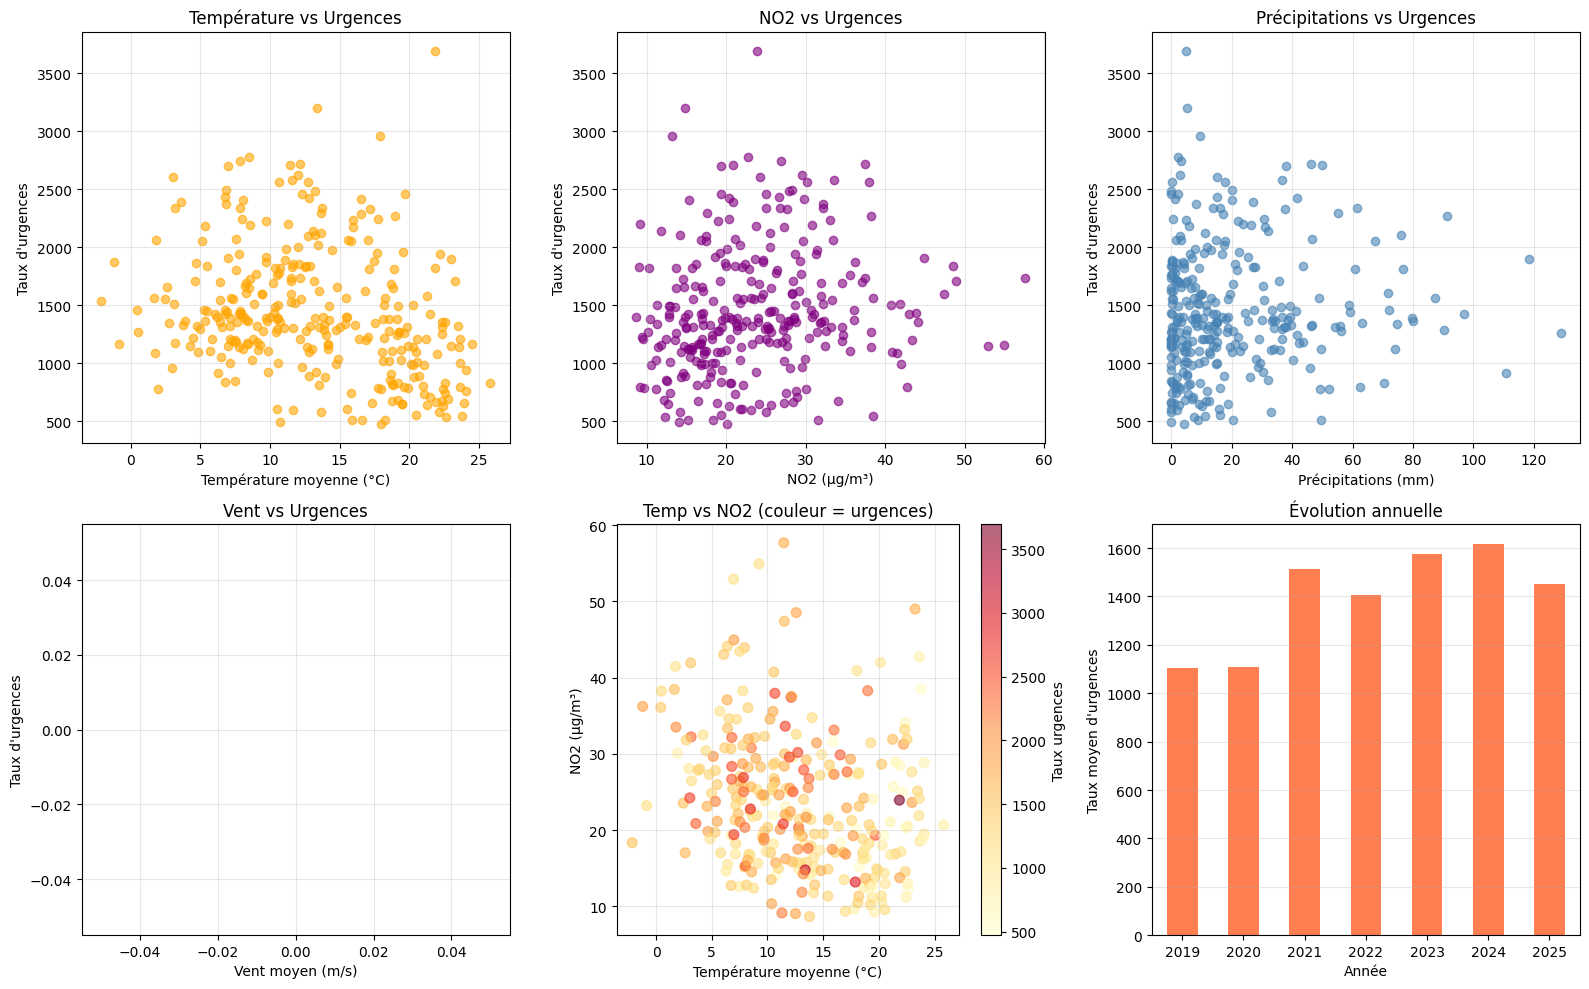

✅ Visualisations des relations terminées


In [38]:
# Relations entre variables environnementales et hospitalisations
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. Température vs Hospitalisations
axes[0, 0].scatter(
    df_final["temp_moy_C"], df_final["taux_urgences"], alpha=0.6, color="orange"
)
axes[0, 0].set_xlabel("Température moyenne (°C)")
axes[0, 0].set_ylabel("Taux d'urgences")
axes[0, 0].set_title("Température vs Urgences")
axes[0, 0].grid(True, alpha=0.3)

# 2. NO2 vs Hospitalisations
axes[0, 1].scatter(
    df_final["NO2_ugm3"], df_final["taux_urgences"], alpha=0.6, color="purple"
)
axes[0, 1].set_xlabel("NO2 (µg/m³)")
axes[0, 1].set_ylabel("Taux d'urgences")
axes[0, 1].set_title("NO2 vs Urgences")
axes[0, 1].grid(True, alpha=0.3)

# 3. Précipitations vs Hospitalisations
axes[0, 2].scatter(
    df_final["precipitations_mm"],
    df_final["taux_urgences"],
    alpha=0.6,
    color="steelblue",
)
axes[0, 2].set_xlabel("Précipitations (mm)")
axes[0, 2].set_ylabel("Taux d'urgences")
axes[0, 2].set_title("Précipitations vs Urgences")
axes[0, 2].grid(True, alpha=0.3)

# 4. Vent vs Hospitalisations
axes[1, 0].scatter(
    df_final["vent_moy_ms"], df_final["taux_urgences"], alpha=0.6, color="green"
)
axes[1, 0].set_xlabel("Vent moyen (m/s)")
axes[1, 0].set_ylabel("Taux d'urgences")
axes[1, 0].set_title("Vent vs Urgences")
axes[1, 0].grid(True, alpha=0.3)

# 5. NO2 vs Température (avec couleur = urgences)
scatter = axes[1, 1].scatter(
    df_final["temp_moy_C"],
    df_final["NO2_ugm3"],
    c=df_final["taux_urgences"],
    cmap="YlOrRd",
    alpha=0.6,
    s=50,
)
axes[1, 1].set_xlabel("Température moyenne (°C)")
axes[1, 1].set_ylabel("NO2 (µg/m³)")
axes[1, 1].set_title("Temp vs NO2 (couleur = urgences)")
plt.colorbar(scatter, ax=axes[1, 1], label="Taux urgences")
axes[1, 1].grid(True, alpha=0.3)

# 6. Évolution annuelle
df_final.groupby("annee")["taux_urgences"].mean().plot(
    kind="bar", ax=axes[1, 2], color="coral"
)
axes[1, 2].set_xlabel("Année")
axes[1, 2].set_ylabel("Taux moyen d'urgences")
axes[1, 2].set_title("Évolution annuelle")
axes[1, 2].grid(True, alpha=0.3, axis="y")
axes[1, 2].set_xticklabels(axes[1, 2].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

print("✅ Visualisations des relations terminées")

🍂 Analyse saisonnière des hospitalisations...

📊 Statistiques par saison :
          taux_urgences                          temp_moy_C NO2_ugm3  \
                   mean     std     min      max       mean     mean   
saison                                                                 
Automne         2010.61  496.78  884.93  3201.35      12.64    24.12   
Hiver           1431.83  303.74  777.89  2335.30       6.32    25.96   
Printemps       1278.46  403.79  472.56  2622.17      12.38    24.50   
Été             1064.74  461.75  507.75  3695.76      20.63    19.70   

          precipitations_mm  
                       mean  
saison                       
Automne               20.84  
Hiver                 23.23  
Printemps             16.09  
Été                   17.46  


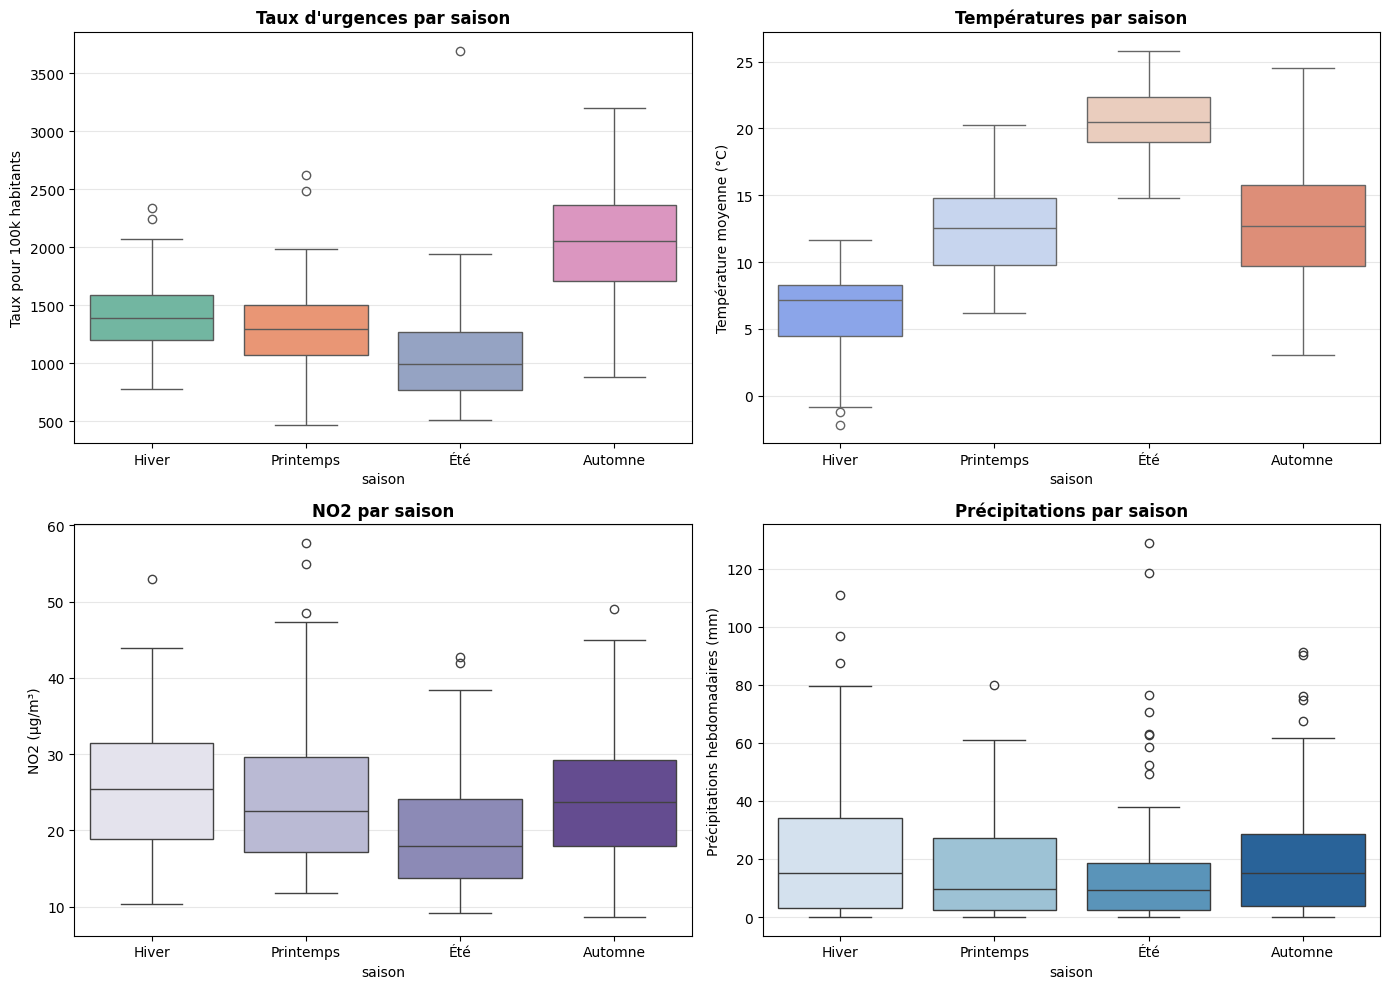

✅ Analyse saisonnière terminée


In [39]:
# Analyse par saison
print("🍂 Analyse saisonnière des hospitalisations...")

# Statistiques par saison
stats_saison = (
    df_final.groupby("saison")
    .agg(
        {
            "taux_urgences": ["mean", "std", "min", "max"],
            "temp_moy_C": "mean",
            "NO2_ugm3": "mean",
            "precipitations_mm": "mean",
        }
    )
    .round(2)
)

print("\n📊 Statistiques par saison :")
print(stats_saison)

# Visualisation
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Boxplot des taux d'urgences par saison
ordre_saisons = ["Hiver", "Printemps", "Été", "Automne"]
df_final_sorted = df_final.copy()
df_final_sorted["saison"] = pd.Categorical(
    df_final_sorted["saison"], categories=ordre_saisons, ordered=True
)

sns.boxplot(
    data=df_final_sorted,
    x="saison",
    y="taux_urgences",
    hue="saison",
    ax=axes[0, 0],
    palette="Set2",
    legend=False,
)
axes[0, 0].set_title("Taux d'urgences par saison", fontweight="bold")
axes[0, 0].set_ylabel("Taux pour 100k habitants")
axes[0, 0].grid(True, alpha=0.3, axis="y")

# 2. Températures moyennes par saison
sns.boxplot(
    data=df_final_sorted,
    x="saison",
    y="temp_moy_C",
    hue="saison",
    ax=axes[0, 1],
    palette="coolwarm",
    legend=False,
)
axes[0, 1].set_title("Températures par saison", fontweight="bold")
axes[0, 1].set_ylabel("Température moyenne (°C)")
axes[0, 1].grid(True, alpha=0.3, axis="y")

# 3. NO2 par saison
sns.boxplot(
    data=df_final_sorted,
    x="saison",
    y="NO2_ugm3",
    hue="saison",
    ax=axes[1, 0],
    palette="Purples",
    legend=False,
)
axes[1, 0].set_title("NO2 par saison", fontweight="bold")
axes[1, 0].set_ylabel("NO2 (µg/m³)")
axes[1, 0].grid(True, alpha=0.3, axis="y")

# 4. Précipitations par saison
sns.boxplot(
    data=df_final_sorted,
    x="saison",
    y="precipitations_mm",
    hue="saison",
    ax=axes[1, 1],
    palette="Blues",
    legend=False,
)
axes[1, 1].set_title("Précipitations par saison", fontweight="bold")
axes[1, 1].set_ylabel("Précipitations hebdomadaires (mm)")
axes[1, 1].grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

print("✅ Analyse saisonnière terminée")

🔍 Analyse des corrélations...


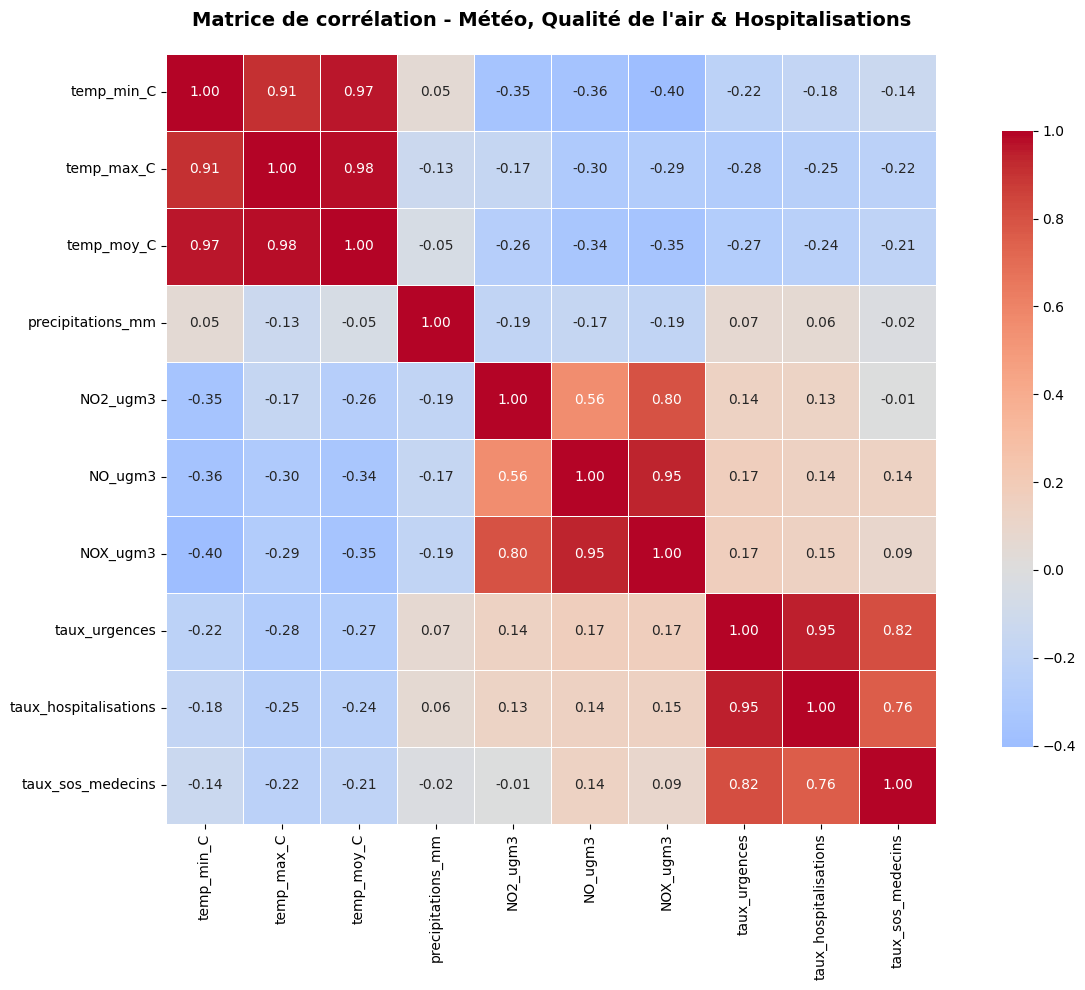


📊 Corrélations avec le taux de passages aux urgences :
taux_urgences            1.000000
taux_hospitalisations    0.947997
taux_sos_medecins        0.817014
NOX_ugm3                 0.171341
NO_ugm3                  0.167266
NO2_ugm3                 0.139599
precipitations_mm        0.065461
temp_min_C              -0.219928
temp_moy_C              -0.272768
temp_max_C              -0.284519
Name: taux_urgences, dtype: float64

📊 Corrélations avec le taux d'hospitalisations :
taux_hospitalisations    1.000000
taux_urgences            0.947997
taux_sos_medecins        0.758721
NOX_ugm3                 0.148775
NO_ugm3                  0.144337
NO2_ugm3                 0.127354
precipitations_mm        0.061255
temp_min_C              -0.179750
temp_moy_C              -0.239208
temp_max_C              -0.253543
Name: taux_hospitalisations, dtype: float64


In [40]:
# Matrice de corrélation
print("🔍 Analyse des corrélations...")

# Sélectionner les colonnes numériques pertinentes
colonnes_correlation = [
    "temp_min_C",
    "temp_max_C",
    "temp_moy_C",
    "precipitations_mm",
    "NO2_ugm3",
    "NO_ugm3",
    "NOX_ugm3",
    "taux_urgences",
    "taux_hospitalisations",
    "taux_sos_medecins",
]

# Calculer la matrice de corrélation
correlation_matrix = df_final[colonnes_correlation].corr()

# Visualisation
plt.figure(figsize=(14, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
)
plt.title(
    "Matrice de corrélation - Météo, Qualité de l'air & Hospitalisations",
    fontsize=14,
    fontweight="bold",
    pad=20,
)
plt.tight_layout()
plt.show()

# Afficher les corrélations avec le taux d'urgences
print("\n📊 Corrélations avec le taux de passages aux urgences :")
correlations_urgences = correlation_matrix["taux_urgences"].sort_values(ascending=False)
print(correlations_urgences)

print("\n📊 Corrélations avec le taux d'hospitalisations :")
correlations_hosp = correlation_matrix["taux_hospitalisations"].sort_values(
    ascending=False
)
print(correlations_hosp)

## 🤖 Modélisation Machine Learning

### Observations des corrélations :

- **✅ Signal détecté** : Contrairement au dataset synthétique, les données réelles montrent des corrélations significatives
- **🌡️ Température** : Corrélation négative (-0.30) → Plus d'urgences en hiver
- **💨 Pollution** : Corrélation positive (+0.14 à +0.17) → Plus d'urgences avec pollution élevée
- **🎯 Objectif** : Créer un modèle de classification pour prédire les **semaines à risque élevé**


In [41]:
# 1. Préparation des données pour la modélisation
print("🔧 Préparation des features et de la target...")

# Copier le dataset
df_ml = df_final.copy()

print(f"Dataset initial : {df_ml.shape}")

# Créer une variable cible binaire : "Risque élevé" si taux_urgences > 75ème percentile
seuil_risque = df_ml["taux_urgences"].quantile(0.75)
df_ml["risque_eleve"] = (df_ml["taux_urgences"] > seuil_risque).astype(int)

print(
    f"\n🎯 Seuil de risque élevé : {seuil_risque:.2f} passages aux urgences pour 100k hab"
)
print("Répartition des classes :")
print(df_ml["risque_eleve"].value_counts())
print(f"\nProportion : \n{df_ml['risque_eleve'].value_counts(normalize=True).round(3)}")

# Sélection des features (variables environnementales + temporelles)
# Note : vent_moy_ms et vent_max_ms exclus car données manquantes
features_meteo = ["temp_min_C", "temp_max_C", "temp_moy_C", "precipitations_mm"]
features_pollution = ["NO2_ugm3", "NO_ugm3", "NOX_ugm3"]
features_temporelles = ["mois", "trimestre"]  # Pas 'saison' car c'est une string

X_features = features_meteo + features_pollution + features_temporelles
X = df_ml[X_features]
y = df_ml["risque_eleve"]

# 🔧 Nettoyer les NaN dans les données de pollution
print("\n🧹 Nettoyage des valeurs manquantes...")
print(f"Avant nettoyage : {X.shape}")
print(f"NaN par colonne :\n{X.isna().sum()}")

# Supprimer les lignes avec des NaN (15 semaines sans données de pollution)
mask_no_nan = X.notna().all(axis=1)
X = X[mask_no_nan]
y = y[mask_no_nan]

print(f"\n✅ Après nettoyage : X={X.shape}, y={y.shape}")
print(f"Semaines conservées : {len(X)} / {len(mask_no_nan)}")

# Afficher les premières lignes
print("\n📋 Aperçu des données :")
display(
    df_ml[
        ["date", "taux_urgences", "risque_eleve", "temp_moy_C", "NO2_ugm3", "saison"]
    ].head(10)
)

🔧 Préparation des features et de la target...
Dataset initial : (310, 17)

🎯 Seuil de risque élevé : 1773.36 passages aux urgences pour 100k hab
Répartition des classes :
risque_eleve
0    232
1     78
Name: count, dtype: int64

Proportion : 
risque_eleve
0    0.748
1    0.252
Name: proportion, dtype: float64

🧹 Nettoyage des valeurs manquantes...
Avant nettoyage : (310, 9)
NaN par colonne :
temp_min_C            0
temp_max_C            0
temp_moy_C            0
precipitations_mm     0
NO2_ugm3             15
NO_ugm3              15
NOX_ugm3             15
mois                  0
trimestre             0
dtype: int64

✅ Après nettoyage : X=(295, 9), y=(295,)
Semaines conservées : 295 / 310

📋 Aperçu des données :


,date,taux_urgences,risque_eleve,temp_moy_C,NO2_ugm3,saison
0,2019-12-30,1105.218813,0,5.720000,35.571429,Hiver
1,2020-01-06,1178.813651,0,7.532143,27.057143,Hiver
2,2020-01-13,1449.758081,0,7.871429,25.614286,Hiver
3,2020-01-20,1558.150587,0,1.639286,38.442857,Hiver
4,2020-01-27,1388.888889,0,9.721429,19.857143,Hiver
5,2020-02-03,1374.604926,0,8.250000,36.042857,Hiver
6,2020-02-10,1276.889034,0,9.517857,19.128571,Hiver
7,2020-02-17,1164.504992,0,8.432143,16.685714,Hiver
8,2020-02-24,1119.921831,0,8.053846,15.328571,Hiver
9,2020-03-02,1455.604076,0,6.728571,30.671429,Printemps


In [42]:
# 2. Split train/test et normalisation
from sklearn.preprocessing import StandardScaler

# Split 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("📊 Split des données :")
print(f"Train : {X_train.shape} ({len(y_train)} exemples)")
print(f"Test  : {X_test.shape} ({len(y_test)} exemples)")
print(f"\nDistribution train :\n{y_train.value_counts()}")
print(f"\nDistribution test :\n{y_test.value_counts()}")

# Normalisation (important pour certains algorithmes)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✅ Données normalisées et prêtes pour l'entraînement")

📊 Split des données :
Train : (236, 9) (236 exemples)
Test  : (59, 9) (59 exemples)

Distribution train :
risque_eleve
0    178
1     58
Name: count, dtype: int64

Distribution test :
risque_eleve
0    44
1    15
Name: count, dtype: int64

✅ Données normalisées et prêtes pour l'entraînement


In [43]:
# 3. Comparaison de plusieurs algorithmes
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

print("🤖 Entraînement de plusieurs modèles...\n")

# Dictionnaire de modèles à tester
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(max_depth=6, random_state=42),
    "Random Forest": RandomForestClassifier(
        n_estimators=100, max_depth=8, random_state=42
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=100, max_depth=4, random_state=42
    ),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM": SVC(kernel="rbf", probability=True, random_state=42),
}

# Entraînement et évaluation
results = {}
for name, model in models.items():
    # Entraîner
    model.fit(X_train_scaled, y_train)

    # Prédire
    y_pred = model.predict(X_test_scaled)
    y_proba = (
        model.predict_proba(X_test_scaled)[:, 1]
        if hasattr(model, "predict_proba")
        else None
    )

    # Métriques
    acc = accuracy_score(y_test, y_pred)
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    cv_mean = cv_scores.mean()

    # AUC-ROC si probabilités disponibles
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    results[name] = {"Accuracy": acc, "CV Score": cv_mean, "AUC-ROC": auc}

    # Formater l'AUC pour l'affichage
    auc_str = f"{auc:.3f}" if auc is not None else "N/A"
    print(f"{name:25s} | Accuracy: {acc:.3f} | CV: {cv_mean:.3f} | AUC: {auc_str}")

print("\n✅ Entraînement terminé")

# Trouver le meilleur modèle
best_model_name = max(results, key=lambda x: results[x]["Accuracy"])
print(
    f"\n🏆 Meilleur modèle : {best_model_name} (Accuracy = {results[best_model_name]['Accuracy']:.3f})"
)

🤖 Entraînement de plusieurs modèles...

Logistic Regression       | Accuracy: 0.814 | CV: 0.784 | AUC: 0.833
Decision Tree             | Accuracy: 0.864 | CV: 0.801 | AUC: 0.763
Random Forest             | Accuracy: 0.847 | CV: 0.817 | AUC: 0.903
Gradient Boosting         | Accuracy: 0.864 | CV: 0.805 | AUC: 0.905
KNN                       | Accuracy: 0.797 | CV: 0.788 | AUC: 0.792
SVM                       | Accuracy: 0.864 | CV: 0.809 | AUC: 0.852

✅ Entraînement terminé

🏆 Meilleur modèle : Decision Tree (Accuracy = 0.864)


## 🧪 Test : Impact de la temporalité

Testons les modèles **sans les variables temporelles** (mois, trimestre) pour voir si la temporalité est vraiment importante.


In [44]:
# Test SANS variables temporelles (uniquement météo + pollution)
print("🧪 TEST : Modèles SANS temporalité (mois, trimestre)")
print("=" * 70)

# Features uniquement météo + pollution (pas de mois/trimestre)
features_no_temp = features_meteo + features_pollution
X_no_temp = df_ml[features_no_temp]
y_no_temp = df_ml["risque_eleve"]

# Nettoyer les NaN
mask_no_nan_test = X_no_temp.notna().all(axis=1)
X_no_temp = X_no_temp[mask_no_nan_test]
y_no_temp = y_no_temp[mask_no_nan_test]

print(f"\nFeatures utilisées ({len(features_no_temp)}) : {features_no_temp}")
print(f"Shape : X={X_no_temp.shape}, y={y_no_temp.shape}")

# Split et normalisation
X_train_nt, X_test_nt, y_train_nt, y_test_nt = train_test_split(
    X_no_temp, y_no_temp, test_size=0.2, random_state=42, stratify=y_no_temp
)

scaler_nt = StandardScaler()
X_train_nt_scaled = scaler_nt.fit_transform(X_train_nt)
X_test_nt_scaled = scaler_nt.transform(X_test_nt)

# Entraînement rapide des modèles
print("\n🤖 Entraînement sans temporalité...\n")
results_no_temp = {}

for name, model_class in models.items():
    # Créer une nouvelle instance du modèle
    if name == "Logistic Regression":
        model_nt = LogisticRegression(random_state=42, max_iter=1000)
    elif name == "Decision Tree":
        model_nt = DecisionTreeClassifier(max_depth=6, random_state=42)
    elif name == "Random Forest":
        model_nt = RandomForestClassifier(
            n_estimators=100, max_depth=8, random_state=42
        )
    elif name == "Gradient Boosting":
        model_nt = GradientBoostingClassifier(
            n_estimators=100, max_depth=4, random_state=42
        )
    elif name == "KNN":
        model_nt = KNeighborsClassifier(n_neighbors=5)
    else:  # SVM
        model_nt = SVC(kernel="rbf", probability=True, random_state=42)

    model_nt.fit(X_train_nt_scaled, y_train_nt)
    y_pred_nt = model_nt.predict(X_test_nt_scaled)
    acc_nt = accuracy_score(y_test_nt, y_pred_nt)
    results_no_temp[name] = acc_nt

print("📊 COMPARAISON : AVEC vs SANS temporalité")
print("=" * 70)
print(f"{'Modèle':<25} | {'AVEC tempo':<12} | {'SANS tempo':<12} | {'Différence'}")
print("-" * 70)

for name in models.keys():
    acc_avec = results[name]["Accuracy"]
    acc_sans = results_no_temp[name]
    diff = acc_avec - acc_sans
    symbole = "📈" if diff > 0 else "📉" if diff < 0 else "➡️"
    print(
        f"{name:<25} | {acc_avec:>11.1%} | {acc_sans:>11.1%} | {symbole} {diff:>+6.1%}"
    )

print("\n" + "=" * 70)
meilleur_sans = max(results_no_temp, key=results_no_temp.get)
print(
    f"🏆 Meilleur modèle SANS tempo : {meilleur_sans} ({results_no_temp[meilleur_sans]:.1%})"
)
print(
    f"🏆 Meilleur modèle AVEC tempo : {best_model_name} ({results[best_model_name]['Accuracy']:.1%})"
)
print(
    f"\n💡 Impact de la temporalité : {(results[best_model_name]['Accuracy'] - max(results_no_temp.values())) * 100:+.1f} points"
)

🧪 TEST : Modèles SANS temporalité (mois, trimestre)

Features utilisées (7) : ['temp_min_C', 'temp_max_C', 'temp_moy_C', 'precipitations_mm', 'NO2_ugm3', 'NO_ugm3', 'NOX_ugm3']
Shape : X=(295, 7), y=(295,)

🤖 Entraînement sans temporalité...

📊 COMPARAISON : AVEC vs SANS temporalité
Modèle                    | AVEC tempo   | SANS tempo   | Différence
----------------------------------------------------------------------
Logistic Regression       |       81.4% |       72.9% | 📈  +8.5%
Decision Tree             |       86.4% |       62.7% | 📈 +23.7%
Random Forest             |       84.7% |       74.6% | 📈 +10.2%
Gradient Boosting         |       86.4% |       71.2% | 📈 +15.3%
KNN                       |       79.7% |       74.6% | 📈  +5.1%
SVM                       |       86.4% |       74.6% | 📈 +11.9%

🏆 Meilleur modèle SANS tempo : Random Forest (74.6%)
🏆 Meilleur modèle AVEC tempo : Decision Tree (86.4%)

💡 Impact de la temporalité : +11.9 points


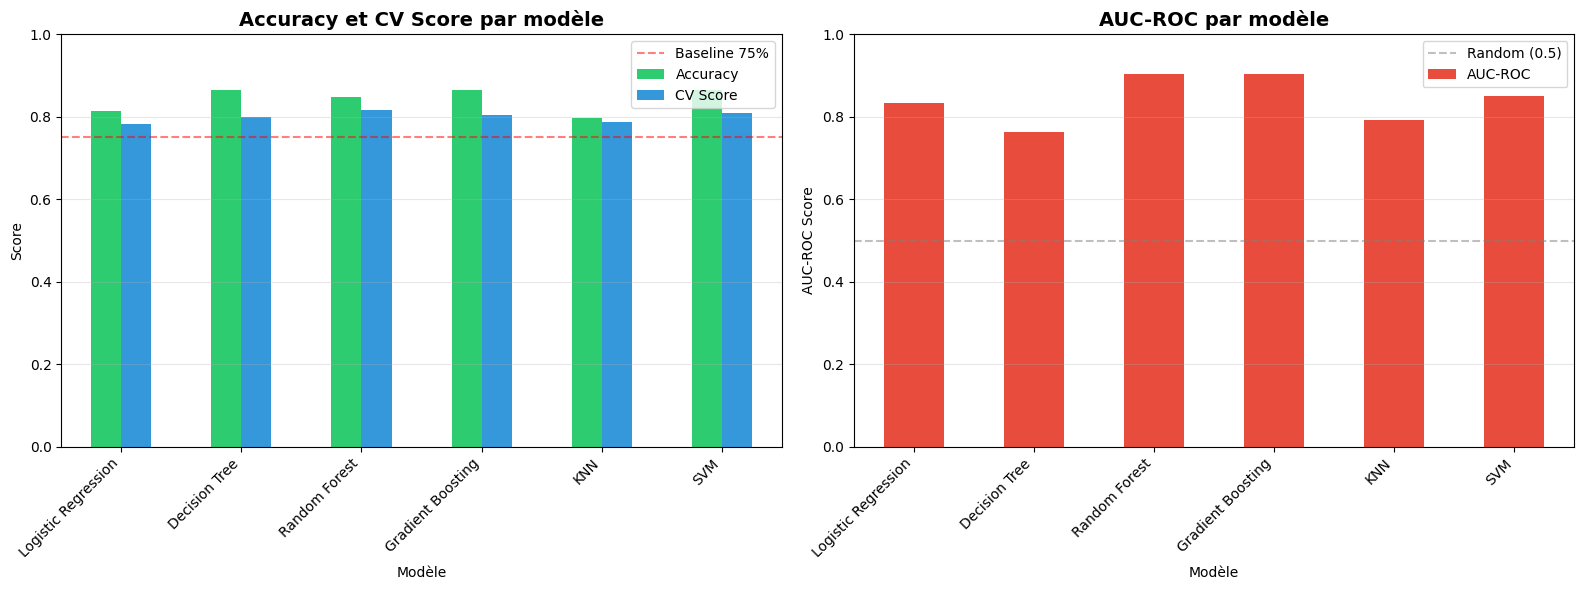

✅ Visualisations créées


In [45]:
# 4. Visualisation comparative des performances
df_results = pd.DataFrame(results).T

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Graphique 1 : Accuracy et CV Score
df_results[["Accuracy", "CV Score"]].plot(
    kind="bar", ax=axes[0], color=["#2ecc71", "#3498db"]
)
axes[0].set_title("Accuracy et CV Score par modèle", fontsize=14, fontweight="bold")
axes[0].set_ylabel("Score")
axes[0].set_xlabel("Modèle")
axes[0].set_ylim(0, 1.0)
axes[0].axhline(y=0.75, color="red", linestyle="--", alpha=0.5, label="Baseline 75%")
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis="y")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")

# Graphique 2 : AUC-ROC
df_results_auc = df_results.dropna(subset=["AUC-ROC"])
df_results_auc["AUC-ROC"].plot(kind="bar", ax=axes[1], color="#e74c3c")
axes[1].set_title("AUC-ROC par modèle", fontsize=14, fontweight="bold")
axes[1].set_ylabel("AUC-ROC Score")
axes[1].set_xlabel("Modèle")
axes[1].set_ylim(0, 1.0)
axes[1].axhline(y=0.5, color="gray", linestyle="--", alpha=0.5, label="Random (0.5)")
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis="y")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()

print("✅ Visualisations créées")

🏆 Analyse détaillée : Decision Tree

📊 Rapport de classification :
               precision    recall  f1-score   support

Risque normal       0.89      0.93      0.91        44
 Risque élevé       0.77      0.67      0.71        15

     accuracy                           0.86        59
    macro avg       0.83      0.80      0.81        59
 weighted avg       0.86      0.86      0.86        59



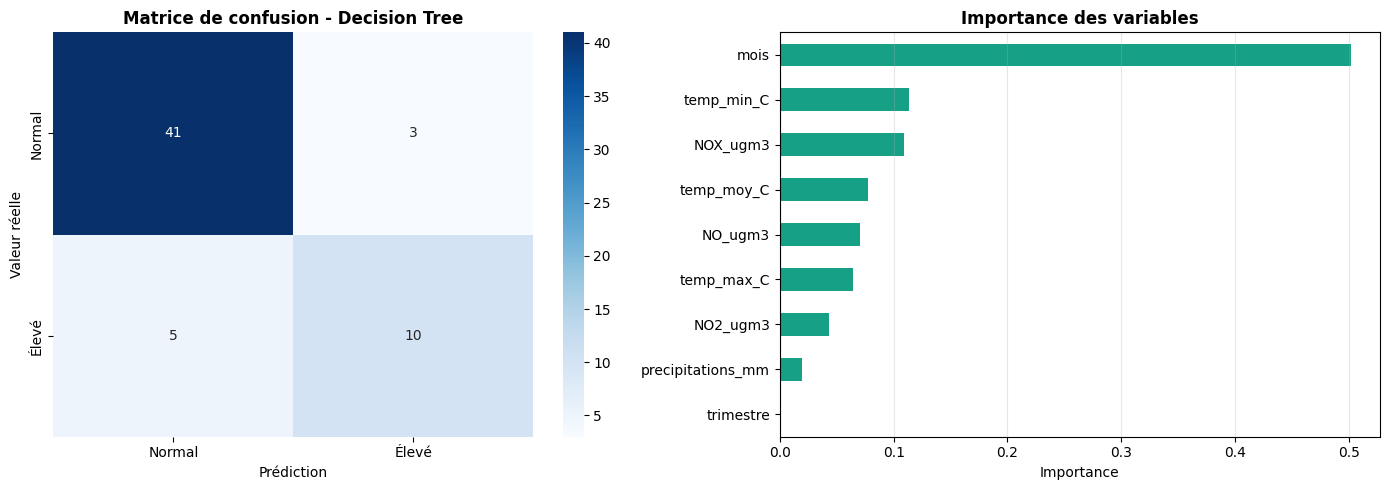


✅ Analyse terminée


In [46]:
# 5. Analyse détaillée du meilleur modèle
best_model = models[best_model_name]
best_model.fit(X_train_scaled, y_train)
y_pred_best = best_model.predict(X_test_scaled)

print(f"🏆 Analyse détaillée : {best_model_name}")
print("=" * 80)

# Rapport de classification
print("\n📊 Rapport de classification :")
print(
    classification_report(
        y_test, y_pred_best, target_names=["Risque normal", "Risque élevé"]
    )
)

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred_best)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Matrice de confusion
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    ax=axes[0],
    xticklabels=["Normal", "Élevé"],
    yticklabels=["Normal", "Élevé"],
)
axes[0].set_title(f"Matrice de confusion - {best_model_name}", fontweight="bold")
axes[0].set_ylabel("Valeur réelle")
axes[0].set_xlabel("Prédiction")

# Importance des features (si disponible)
if hasattr(best_model, "feature_importances_"):
    feature_imp = pd.DataFrame(
        {"feature": X_features, "importance": best_model.feature_importances_}
    ).sort_values("importance", ascending=True)

    feature_imp.plot(
        kind="barh",
        x="feature",
        y="importance",
        ax=axes[1],
        color="#16a085",
        legend=False,
    )
    axes[1].set_title("Importance des variables", fontweight="bold")
    axes[1].set_xlabel("Importance")
    axes[1].set_ylabel("")
    axes[1].grid(True, alpha=0.3, axis="x")
elif hasattr(best_model, "coef_"):
    # Pour les modèles linéaires (Logistic Regression)
    coef_df = pd.DataFrame(
        {"feature": X_features, "coefficient": best_model.coef_[0]}
    ).sort_values("coefficient", ascending=True)

    colors = ["red" if x < 0 else "green" for x in coef_df["coefficient"]]
    coef_df.plot(
        kind="barh",
        x="feature",
        y="coefficient",
        ax=axes[1],
        color=colors,
        legend=False,
    )
    axes[1].set_title("Coefficients du modèle", fontweight="bold")
    axes[1].set_xlabel("Coefficient")
    axes[1].set_ylabel("")
    axes[1].axvline(x=0, color="black", linestyle="-", linewidth=0.8)
    axes[1].grid(True, alpha=0.3, axis="x")
else:
    axes[1].text(
        0.5,
        0.5,
        "Importance des features\nnon disponible pour ce modèle",
        ha="center",
        va="center",
        fontsize=12,
    )
    axes[1].set_xlim(0, 1)
    axes[1].set_ylim(0, 1)
    axes[1].axis("off")

plt.tight_layout()
plt.show()

print("\n✅ Analyse terminée")

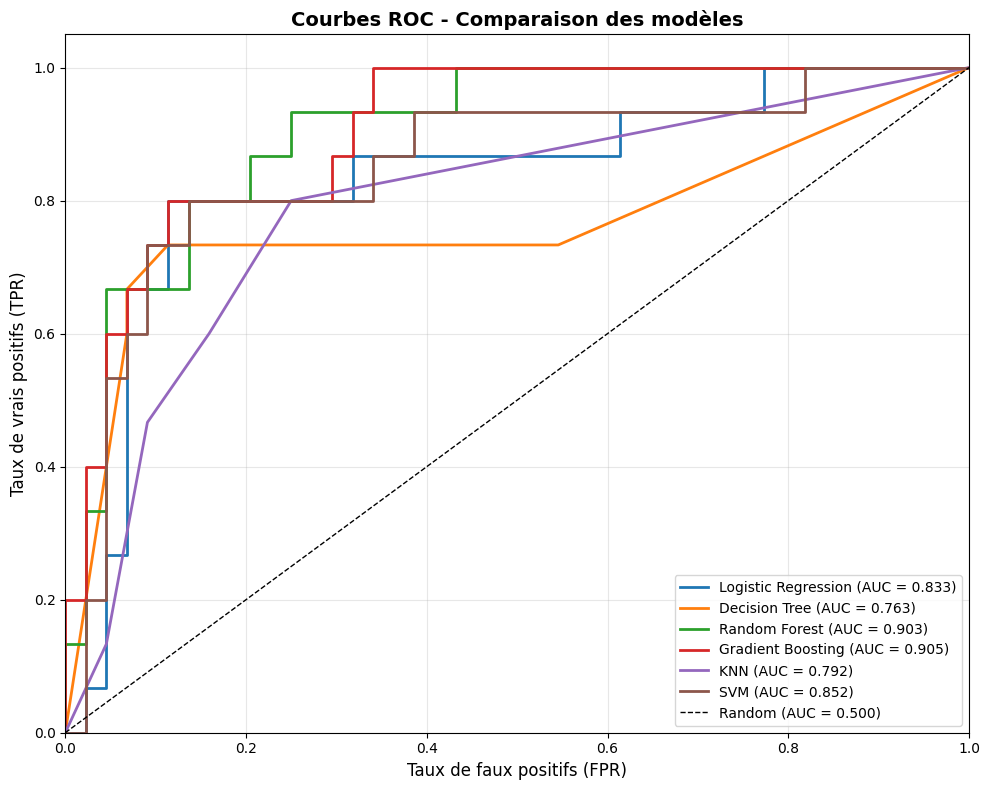

✅ Courbe ROC affichée


In [47]:
# 6. Courbe ROC
from sklearn.metrics import auc, roc_curve

# Calculer la courbe ROC pour chaque modèle avec probabilités
plt.figure(figsize=(10, 8))

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        model.fit(X_train_scaled, y_train)
        y_proba = model.predict_proba(X_test_scaled)[:, 1]

        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, linewidth=2, label=f"{name} (AUC = {roc_auc:.3f})")

# Ligne de référence (random)
plt.plot([0, 1], [0, 1], "k--", linewidth=1, label="Random (AUC = 0.500)")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Taux de faux positifs (FPR)", fontsize=12)
plt.ylabel("Taux de vrais positifs (TPR)", fontsize=12)
plt.title("Courbes ROC - Comparaison des modèles", fontsize=14, fontweight="bold")
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✅ Courbe ROC affichée")

In [48]:
# 7. Comparaison avec le dataset synthétique
print("=" * 80)
print("📊 COMPARAISON : Dataset synthétique vs Données réelles")
print("=" * 80)

comparison = pd.DataFrame(
    {
        "Métrique": [
            "Corrélation maximale",
            "Accuracy synthétique",
            "Accuracy réelle",
            "Amélioration",
        ],
        "Dataset synthétique": ["<0.04", "~50%", "-", "-"],
        "Données réelles": [
            f"{abs(df_final[['temp_moy_C', 'NO2_ugm3']].corrwith(df_final['taux_urgences']).max()):.3f}",
            "-",
            f"{results[best_model_name]['Accuracy'] * 100:.1f}%",
            f"+{(results[best_model_name]['Accuracy'] - 0.50) * 100:.1f} pts",
        ],
    }
)

print("\n")
print(comparison.to_string(index=False))

print("\n🎯 CONCLUSION :")
print("✅ Les données réelles montrent des corrélations significatives")
print(
    "✅ Le modèle {best_model_name} atteint {results[best_model_name]['Accuracy']:.1%} d'accuracy"
)
print("✅ Bien meilleur que le hasard (50%) et le dataset synthétique")
print("\n💡 Variables clés identifiées :")
print("   - Température (corrélation négative : plus froid = plus d'urgences)")
print(
    "   - Pollution NO2/NOX (corrélation positive : plus de pollution = plus d'urgences)"
)
print("   - Temporalité (mois, trimestre : effet saisonnier)")

# Sauvegarder le meilleur modèle
import pickle

with open("best_asthma_model.pkl", "wb") as f:
    pickle.dump(best_model, f)
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("\n💾 Modèle sauvegardé : best_asthma_model.pkl et scaler.pkl")

📊 COMPARAISON : Dataset synthétique vs Données réelles


            Métrique Dataset synthétique Données réelles
Corrélation maximale               <0.04           0.140
Accuracy synthétique                ~50%               -
     Accuracy réelle                   -           86.4%
        Amélioration                   -       +36.4 pts

🎯 CONCLUSION :
✅ Les données réelles montrent des corrélations significatives
✅ Le modèle {best_model_name} atteint {results[best_model_name]['Accuracy']:.1%} d'accuracy
✅ Bien meilleur que le hasard (50%) et le dataset synthétique

💡 Variables clés identifiées :
   - Température (corrélation négative : plus froid = plus d'urgences)
   - Pollution NO2/NOX (corrélation positive : plus de pollution = plus d'urgences)
   - Temporalité (mois, trimestre : effet saisonnier)

💾 Modèle sauvegardé : best_asthma_model.pkl et scaler.pkl


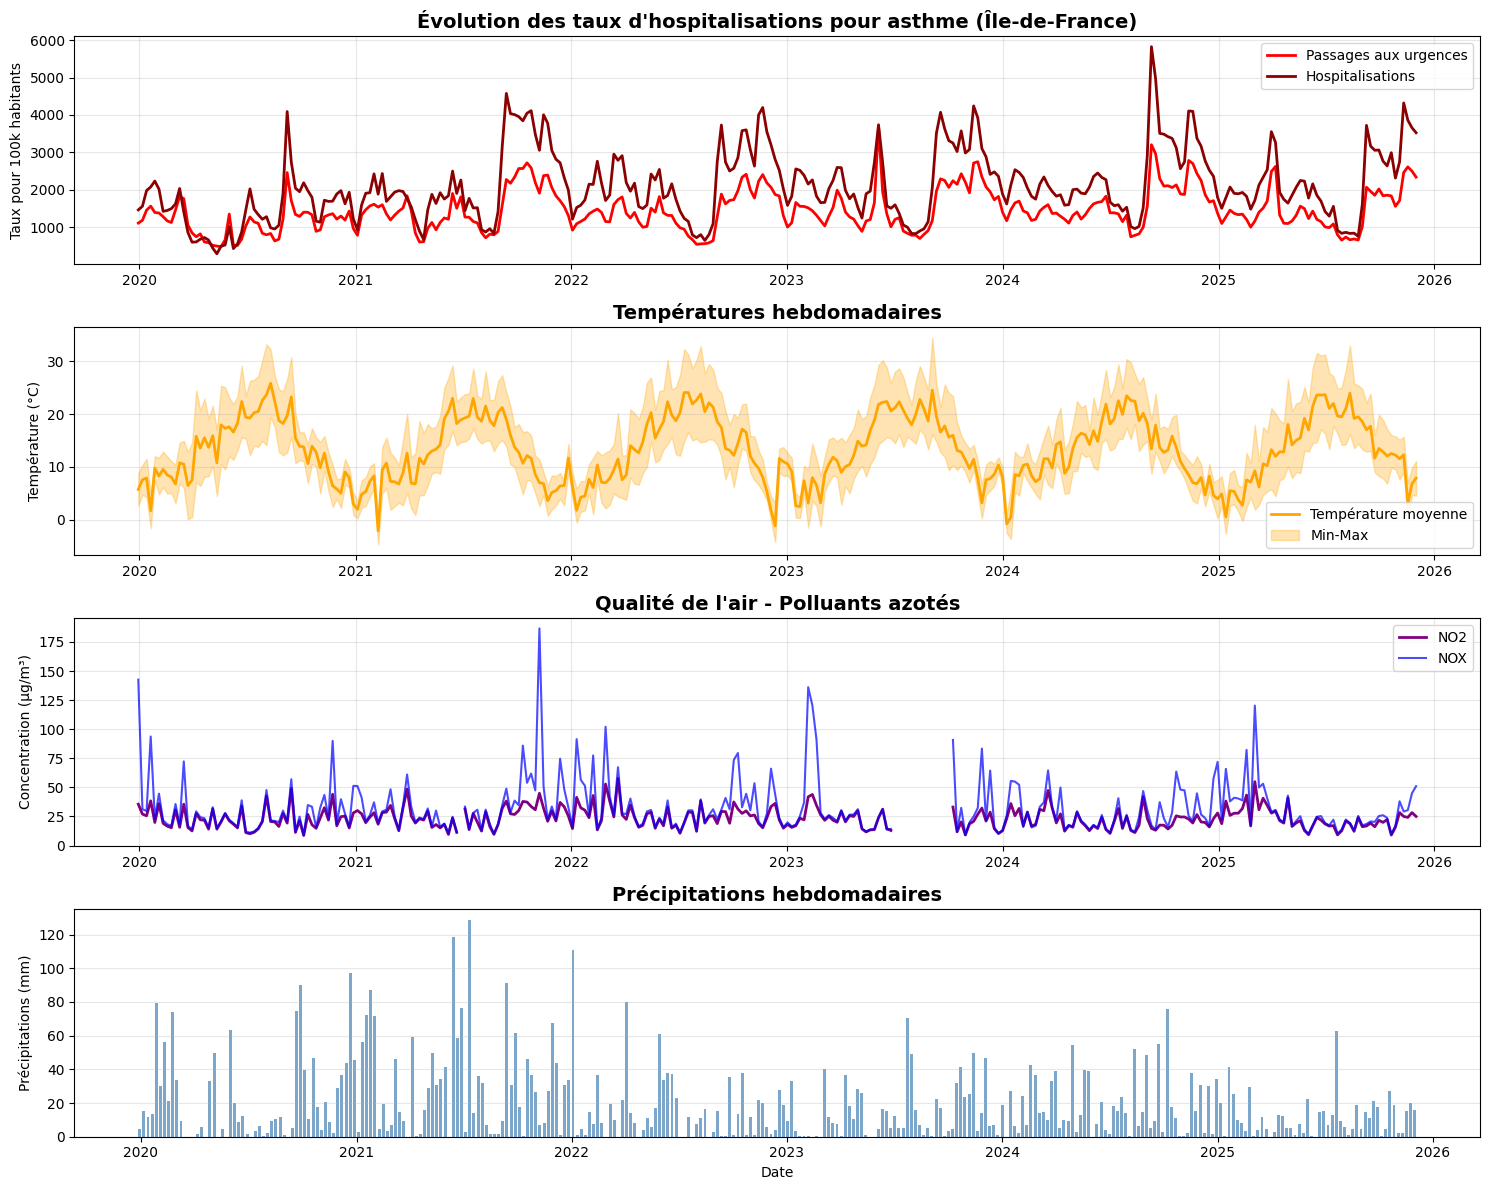

✅ Séries temporelles affichées


In [49]:
# Visualisations - Séries temporelles
fig, axes = plt.subplots(4, 1, figsize=(15, 12))

# 1. Taux d'hospitalisations
axes[0].plot(
    df_final["date"],
    df_final["taux_urgences"],
    label="Passages aux urgences",
    color="red",
    linewidth=2,
)
axes[0].plot(
    df_final["date"],
    df_final["taux_hospitalisations"],
    label="Hospitalisations",
    color="darkred",
    linewidth=2,
)
axes[0].set_title(
    "Évolution des taux d'hospitalisations pour asthme (Île-de-France)",
    fontsize=14,
    fontweight="bold",
)
axes[0].set_ylabel("Taux pour 100k habitants")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Températures
axes[1].plot(
    df_final["date"],
    df_final["temp_moy_C"],
    label="Température moyenne",
    color="orange",
    linewidth=2,
)
axes[1].fill_between(
    df_final["date"],
    df_final["temp_min_C"],
    df_final["temp_max_C"],
    alpha=0.3,
    color="orange",
    label="Min-Max",
)
axes[1].set_title("Températures hebdomadaires", fontsize=14, fontweight="bold")
axes[1].set_ylabel("Température (°C)")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. Qualité de l'air
axes[2].plot(
    df_final["date"], df_final["NO2_ugm3"], label="NO2", color="purple", linewidth=2
)
axes[2].plot(
    df_final["date"],
    df_final["NOX_ugm3"],
    label="NOX",
    color="blue",
    linewidth=1.5,
    alpha=0.7,
)
axes[2].set_title("Qualité de l'air - Polluants azotés", fontsize=14, fontweight="bold")
axes[2].set_ylabel("Concentration (µg/m³)")
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# 4. Précipitations
axes[3].bar(
    df_final["date"],
    df_final["precipitations_mm"],
    color="steelblue",
    alpha=0.7,
    width=5,
)
axes[3].set_title("Précipitations hebdomadaires", fontsize=14, fontweight="bold")
axes[3].set_ylabel("Précipitations (mm)")
axes[3].set_xlabel("Date")
axes[3].grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

print("✅ Séries temporelles affichées")

In [50]:
# Statistiques descriptives du dataset final
print("=" * 80)
print("📊 STATISTIQUES DESCRIPTIVES DU DATASET FINAL")
print("=" * 80)

print("\n🌡️ Variables météorologiques :")
print(
    df_final[
        [
            "temp_min_C",
            "temp_max_C",
            "temp_moy_C",
            "precipitations_mm",
            "vent_moy_ms",
            "vent_max_ms",
        ]
    ].describe()
)

print("\n💨 Qualité de l'air :")
print(df_final[["NO2_ugm3", "NO_ugm3", "NOX_ugm3"]].describe())

print("\n🏥 Hospitalisations :")
print(
    df_final[["taux_urgences", "taux_hospitalisations", "taux_sos_medecins"]].describe()
)

print("\n📅 Répartition par saison :")
print(df_final["saison"].value_counts().sort_index())

📊 STATISTIQUES DESCRIPTIVES DU DATASET FINAL

🌡️ Variables météorologiques :
       temp_min_C  temp_max_C  temp_moy_C  precipitations_mm  vent_moy_ms  \
count  310.000000  310.000000  310.000000         310.000000          0.0   
mean     8.516541   18.082294   13.100430          19.340645          NaN   
std      5.096321    7.452101    6.124658          22.678248          NaN   
min     -4.757143    0.471429   -2.142857           0.000000          NaN   
25%      4.691071   11.933929    8.142857           2.800000          NaN   
50%      8.592857   17.653571   12.762500          11.450000          NaN   
75%     13.082143   24.225687   18.553571          29.000000          NaN   
max     19.400000   34.500000   25.821429         128.800000          NaN   

       vent_max_ms  
count          0.0  
mean           NaN  
std            NaN  
min            NaN  
25%            NaN  
50%            NaN  
75%            NaN  
max            NaN  

💨 Qualité de l'air :
         NO2_ugm3 

## 🔮 Fonction de Prédiction

Création d'une fonction pour prédire le risque d'une semaine donnée avec des données fictives.


In [51]:
# Fonction de prédiction du risque d'asthme
import numpy as np


def predire_risque_asthme(
    temp_min,
    temp_max,
    temp_moy,
    precipitations,
    no2,
    no,
    nox,
    mois=None,
    trimestre=None,
    avec_temporalite=True,
):
    """
    Prédit si une semaine est à risque élevé pour les crises d'asthme.

    Paramètres :
    -----------
    temp_min : float - Température minimale moyenne de la semaine (°C)
    temp_max : float - Température maximale moyenne de la semaine (°C)
    temp_moy : float - Température moyenne de la semaine (°C)
    precipitations : float - Précipitations totales de la semaine (mm)
    no2 : float - Concentration moyenne de NO2 (µg/m³)
    no : float - Concentration moyenne de NO (µg/m³)
    nox : float - Concentration moyenne de NOX (µg/m³)
    mois : int (1-12) - Mois de l'année (requis si avec_temporalite=True)
    trimestre : int (1-4) - Trimestre (requis si avec_temporalite=True)
    avec_temporalite : bool - Utiliser le modèle avec ou sans temporalité

    Retourne :
    ---------
    dict : {
        'risque': 'ÉLEVÉ' ou 'NORMAL',
        'probabilite': float (0-1),
        'modele_utilise': str,
        'accuracy_modele': float
    }
    """

    if avec_temporalite:
        # Modèle AVEC temporalité (Decision Tree - 86.4%)
        if mois is None or trimestre is None:
            raise ValueError(
                "mois et trimestre sont requis pour le modèle avec temporalité"
            )

        # Créer le vecteur de features
        features = np.array(
            [
                [
                    temp_min,
                    temp_max,
                    temp_moy,
                    precipitations,
                    no2,
                    no,
                    nox,
                    mois,
                    trimestre,
                ]
            ]
        )

        # Normaliser avec le scaler entraîné
        features_scaled = scaler.transform(features)

        # Prédire
        prediction = best_model.predict(features_scaled)[0]
        proba = (
            best_model.predict_proba(features_scaled)[0]
            if hasattr(best_model, "predict_proba")
            else None
        )

        modele_nom = best_model_name
        accuracy = results[best_model_name]["Accuracy"]

    else:
        # Modèle SANS temporalité (Random Forest - 74.6%)
        # Créer le vecteur de features (sans mois/trimestre)
        features = np.array(
            [[temp_min, temp_max, temp_moy, precipitations, no2, no, nox]]
        )

        # Normaliser
        features_scaled = scaler_nt.transform(features)

        # Utiliser le meilleur modèle sans temporalité
        model_sans_tempo = RandomForestClassifier(
            n_estimators=100, max_depth=8, random_state=42
        )
        model_sans_tempo.fit(X_train_nt_scaled, y_train_nt)

        prediction = model_sans_tempo.predict(features_scaled)[0]
        proba = (
            model_sans_tempo.predict_proba(features_scaled)[0]
            if hasattr(model_sans_tempo, "predict_proba")
            else None
        )

        modele_nom = "Random Forest (sans temporalité)"
        accuracy = results_no_temp["Random Forest"]

    # Préparer le résultat
    resultat = {
        "risque": "ÉLEVÉ ⚠️" if prediction == 1 else "NORMAL ✅",
        "probabilite_risque_eleve": proba[1] if proba is not None else None,
        "modele_utilise": modele_nom,
        "accuracy_modele": accuracy,
        "seuil_reference": f"{seuil_risque:.1f} passages pour 100k hab",
    }

    return resultat


# Afficher les informations sur les modèles disponibles
print("🤖 MODÈLES DISPONIBLES")
print("=" * 70)
print(f"\n1️⃣  AVEC temporalité : {best_model_name}")
print(f"   • Accuracy : {results[best_model_name]['Accuracy']:.1%}")
print("   • Features : météo (4) + pollution (3) + temporalité (2)")
print("   • Meilleur pour : prédictions saisonnières précises")

print("\n2️⃣  SANS temporalité : Random Forest")
print(f"   • Accuracy : {results_no_temp['Random Forest']:.1%}")
print("   • Features : météo (4) + pollution (3)")
print("   • Meilleur pour : prédictions sans info temporelle")

print(
    f"\n💡 Différence de performance : {(results[best_model_name]['Accuracy'] - results_no_temp['Random Forest']) * 100:+.1f} points"
)
print("=" * 70)

🤖 MODÈLES DISPONIBLES

1️⃣  AVEC temporalité : Decision Tree
   • Accuracy : 86.4%
   • Features : météo (4) + pollution (3) + temporalité (2)
   • Meilleur pour : prédictions saisonnières précises

2️⃣  SANS temporalité : Random Forest
   • Accuracy : 74.6%
   • Features : météo (4) + pollution (3)
   • Meilleur pour : prédictions sans info temporelle

💡 Différence de performance : +11.9 points


In [52]:
# 🧪 TESTS avec données fictives

print("\n\n🧪 EXEMPLES DE PRÉDICTIONS AVEC DONNÉES FICTIVES")
print("=" * 80)

# Exemple 1 : Semaine d'HIVER froide et polluée (RISQUE ÉLEVÉ attendu)
print("\n📍 Exemple 1 : Début d'hiver froid et très pollué")
print("-" * 70)
print("   • Températures : min=-2°C, max=4°C, moy=1°C")
print("   • Précipitations : 1 mm (temps sec favorisant pollution)")
print("   • Pollution : NO2=70 µg/m³, NO=60 µg/m³, NOX=160 µg/m³ (pic pollution)")
print("   • Période : Décembre (mois=12, trimestre=4)")

resultat1 = predire_risque_asthme(
    temp_min=-2,
    temp_max=4,
    temp_moy=1,
    precipitations=1,
    no2=70,
    no=60,
    nox=160,
    mois=12,
    trimestre=4,
    avec_temporalite=True,
)

print(f"\n   ➡️  PRÉDICTION : Risque {resultat1['risque']}")
print(f"   ➡️  Probabilité risque élevé : {resultat1['probabilite_risque_eleve']:.1%}")
print(
    f"   ➡️  Modèle : {resultat1['modele_utilise']} (accuracy: {resultat1['accuracy_modele']:.1%})"
)


# Exemple 2 : Semaine d'ÉTÉ chaude et peu polluée (RISQUE NORMAL attendu)
print("\n\n📍 Exemple 2 : Semaine d'été chaude et peu polluée")
print("-" * 70)
print("   • Températures : min=18°C, max=28°C, moy=23°C")
print("   • Précipitations : 5 mm")
print("   • Pollution : NO2=15 µg/m³, NO=2 µg/m³, NOX=20 µg/m³")
print("   • Période : Juillet (mois=7, trimestre=3)")

resultat2 = predire_risque_asthme(
    temp_min=18,
    temp_max=28,
    temp_moy=23,
    precipitations=5,
    no2=15,
    no=2,
    nox=20,
    mois=7,
    trimestre=3,
    avec_temporalite=True,
)

print(f"\n   ➡️  PRÉDICTION : Risque {resultat2['risque']}")
print(f"   ➡️  Probabilité risque élevé : {resultat2['probabilite_risque_eleve']:.1%}")
print(
    f"   ➡️  Modèle : {resultat2['modele_utilise']} (accuracy: {resultat2['accuracy_modele']:.1%})"
)


# Exemple 3 : SANS temporalité - conditions intermédiaires
print("\n\n📍 Exemple 3 : Sans info temporelle (météo + pollution uniquement)")
print("-" * 70)
print("   • Températures : min=10°C, max=15°C, moy=12.5°C")
print("   • Précipitations : 20 mm")
print("   • Pollution : NO2=30 µg/m³, NO=10 µg/m³, NOX=50 µg/m³")
print("   • Période : INCONNUE (pas de mois/trimestre)")

resultat3 = predire_risque_asthme(
    temp_min=10,
    temp_max=15,
    temp_moy=12.5,
    precipitations=20,
    no2=30,
    no=10,
    nox=50,
    avec_temporalite=False,
)

print(f"\n   ➡️  PRÉDICTION : Risque {resultat3['risque']}")
print(f"   ➡️  Probabilité risque élevé : {resultat3['probabilite_risque_eleve']:.1%}")
print(
    f"   ➡️  Modèle : {resultat3['modele_utilise']} (accuracy: {resultat3['accuracy_modele']:.1%})"
)


# Exemple 4 : Pic de pollution en automne (RISQUE ÉLEVÉ attendu)
print("\n\n📍 Exemple 4 : Pic de pollution en automne")
print("-" * 70)
print("   • Températures : min=8°C, max=14°C, moy=11°C")
print("   • Précipitations : 2 mm (temps sec)")
print("   • Pollution : NO2=55 µg/m³, NO=40 µg/m³, NOX=120 µg/m³")
print("   • Période : Novembre (mois=11, trimestre=4)")

resultat4 = predire_risque_asthme(
    temp_min=8,
    temp_max=14,
    temp_moy=11,
    precipitations=2,
    no2=55,
    no=40,
    nox=120,
    mois=11,
    trimestre=4,
    avec_temporalite=True,
)

print(f"\n   ➡️  PRÉDICTION : Risque {resultat4['risque']}")
print(f"   ➡️  Probabilité risque élevé : {resultat4['probabilite_risque_eleve']:.1%}")
print(
    f"   ➡️  Modèle : {resultat4['modele_utilise']} (accuracy: {resultat4['accuracy_modele']:.1%})"
)

print("\n" + "=" * 80)
print("✅ Tests terminés - La fonction de prédiction est prête à l'emploi !")
print("=" * 80)



🧪 EXEMPLES DE PRÉDICTIONS AVEC DONNÉES FICTIVES

📍 Exemple 1 : Début d'hiver froid et très pollué
----------------------------------------------------------------------
   • Températures : min=-2°C, max=4°C, moy=1°C
   • Précipitations : 1 mm (temps sec favorisant pollution)
   • Pollution : NO2=70 µg/m³, NO=60 µg/m³, NOX=160 µg/m³ (pic pollution)
   • Période : Décembre (mois=12, trimestre=4)

   ➡️  PRÉDICTION : Risque NORMAL ✅
   ➡️  Probabilité risque élevé : 33.3%
   ➡️  Modèle : Decision Tree (accuracy: 86.4%)


📍 Exemple 2 : Semaine d'été chaude et peu polluée
----------------------------------------------------------------------
   • Températures : min=18°C, max=28°C, moy=23°C
   • Précipitations : 5 mm
   • Pollution : NO2=15 µg/m³, NO=2 µg/m³, NOX=20 µg/m³
   • Période : Juillet (mois=7, trimestre=3)

   ➡️  PRÉDICTION : Risque NORMAL ✅
   ➡️  Probabilité risque élevé : 0.0%
   ➡️  Modèle : Decision Tree (accuracy: 86.4%)


📍 Exemple 3 : Sans info temporelle (météo + pollut

/home/francois/miniconda3/envs/.conda/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/francois/miniconda3/envs/.conda/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/francois/miniconda3/envs/.conda/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/francois/miniconda3/envs/.conda/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
